In [ ]:
import torch
import random
import torch.nn as nn
from torch.optim import SGD
import torchvision.utils as vutils
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import os
import numpy as np
import tensorflow as tf
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report
from sklearn import metrics
simplefilter("ignore", category=ConvergenceWarning)
%matplotlib inline

# Thank you Prof. Ver Steeg - Abdullah
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: cuda


## Project Abstract
In this project, **we developed an AI model** to differentiate between real and fake facial images. With **preparation** of our datasets and careful separation of training and validation sets, we aimed to maintain the integrity of our model evaluation. The process allowed us to observe the model's learning progress and generalization capabilities, **enhancing its accuracy** in identifying the authenticity of faces in an era of sophisticated digital realism.



## Overview
**We are importing various tools** to assist us in working with neural networks, managing data, and creating graphs.

The data set can be found here: https://www.kaggle.com/datasets/sachchitkunichetty/rvf10k

The directory structure is slightly altered to make reading the files easier (see comment below).

In [ ]:
# NOTE: If running on Anaconda/Jupyter upload rvf10k to same directory as notebook and skip execution of this cell
#       If running on colab, upload .zip to root dir, run this cell, refresh file explorer and then and extract rvf10k to root dir
#       Reformatted .zip file found here: https://www.dropbox.com/scl/fi/ljj05rsfvg9wpb86z8p7l/archive.zip?rlkey=cik82pquhcw1yt2fack0bveso&dl=0
!unzip archive.zip

## Real and Fake Images Showcase
**We display one sample image from each dataset** to showcase the realism of fake face pictures today. This highlights our goal: creating an AI that can tell us this face we are looking at might be fake.

Real Face


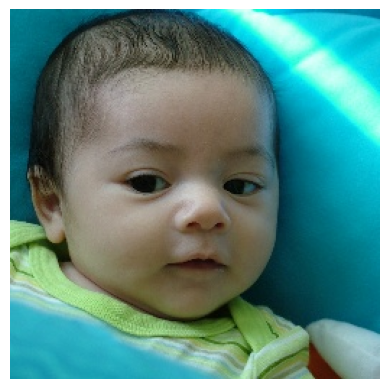

Fake Face


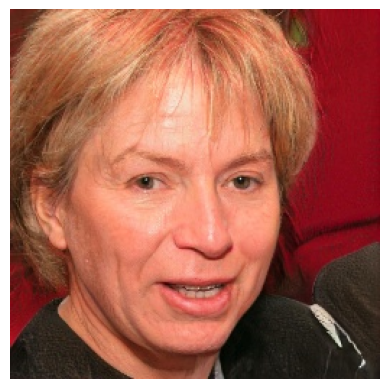

In [ ]:
print("Real Face")
img = mpimg.imread('rvf10k/train/real/00000.jpg')
plt.imshow(img)
plt.axis('off')
plt.show()

print("Fake Face")
img = mpimg.imread('rvf10k/train/fake/002KDWZBHU.jpg')
plt.imshow(img)
plt.axis('off')
plt.show()

As you can no doubt see, the generation of fake faces are pretty convincing! Skimming through the images, it is pretty hard to tell which ones are real and which ones are fake without careful scrutinization. So lets see if a CNN can do any better.

# Setting Up the Workspace for Image Dataset Handling

In this block, we're setting up our workspace to handle a dataset of images. We specify where to find the dataset, then load two files that list the **training** and **validation images**. Then, we define a function to load these images and their respective labels ensuring each image exists and is the correct size. Finally, we use this function to load our **training** and **validation** sets, preparing our data for the next steps in our project.

Thankfully, the dataset itself was relatively clean and ready to go, so not much preprocessing was required at all.

In [ ]:
dataset = 'rvf10k'

# Path to .csv files for both the training and validation datasets
trainingCSVPath = os.path.join(dataset, 'train.csv')
validationCSVPath = os.path.join(dataset, 'valid.csv')

##print(train_csv_path)
##print(valid_csv_path)

trainingDataframe = pd.read_csv(trainingCSVPath)
validationDataframe = pd.read_csv(validationCSVPath)

def load(dataframe, subset):
    images = []
    labels = []

    for index, row in dataframe.iterrows():
      row = dataframe.loc[index]

      # Path of the current folder we are working with (train/val)
      image_path = os.path.join(dataset, row['path'])
      ##print(image_path)
      if os.path.exists(image_path):
          image = cv2.imread(image_path)
          if image is not None:
              # Images are already 256 x 256 but this can't hurt
              image = cv2.resize(image, (256, 256))
              images.append(image)
              labels.append(row['label_str'])
          else:
              print("Error loading image")
      else:
          print("Image path not found: ")
          print(image_path)

    return images, labels

trainingImages, trainingLabels = load(trainingDataframe, 'train')
validationImages, validationLabels = load(validationDataframe, 'valid')

# Undersampling Training Data

In this code block, we undersample our training dataset to match the lenght of our verification dataset. This is used for our CNN later. We print out some images of both sets just so we can check by hand that these images do indeed belong to their respective "real"/"fake" sets in the data as a sanity check.


Length of undersampled training images: 3000
Length of undersampled training labels: 3000


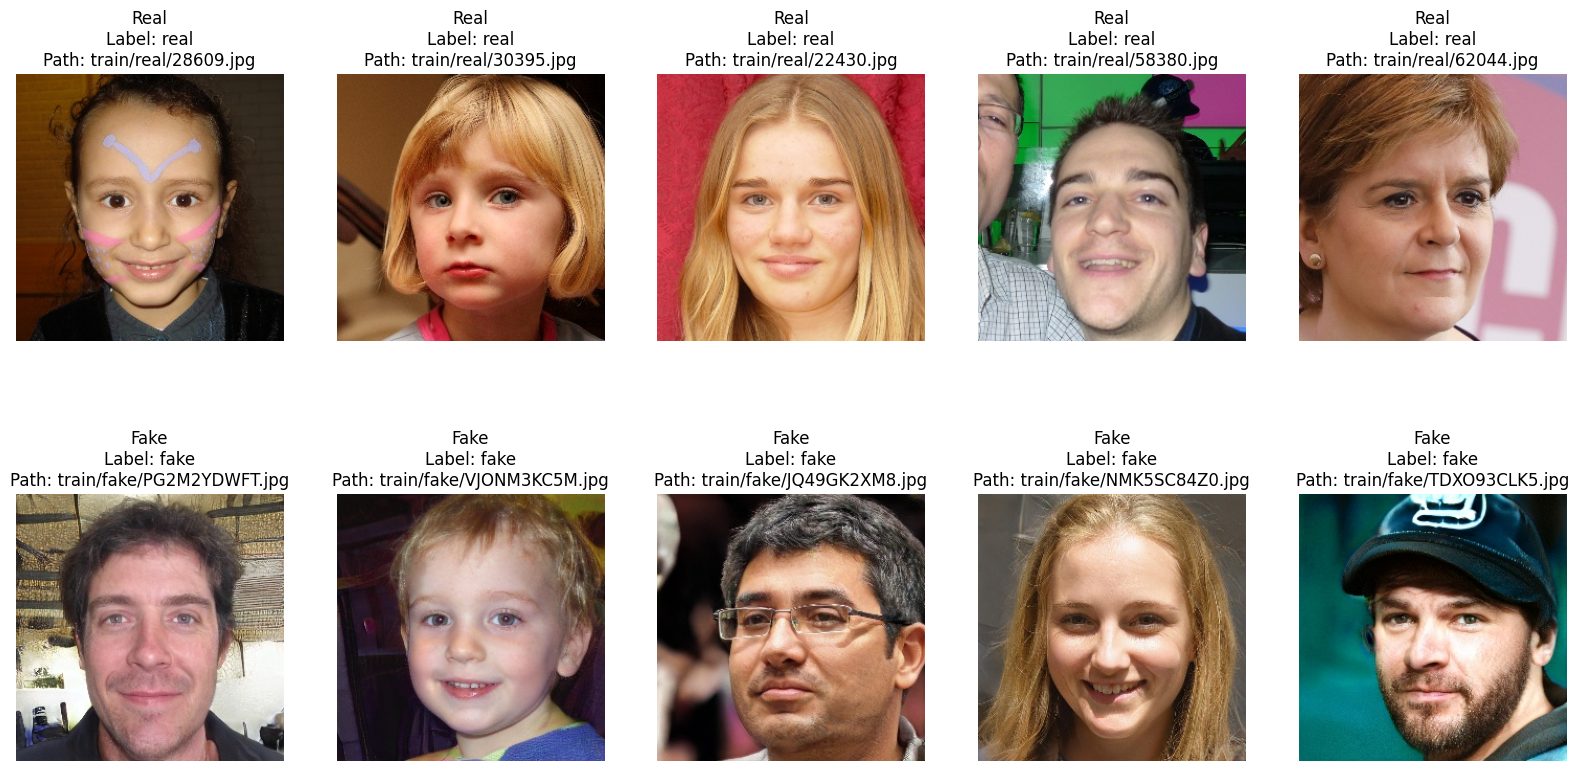

In [ ]:
##print(len(train_images))
##print(len(train_labels))

##print(len(valid_images))
##print(len(valid_labels))

# In this case len(validationImages) is smaller
n = min(len(trainingImages), len(validationImages))
indices = random.sample(range(len(trainingImages)), n)

# Undersample training data to length of validation data
undersampledTrainingImages = [trainingImages[i] for i in indices]
undersampledTrainingLabels = [trainingImages[i] for i in indices]


print("Length of undersampled training images:", len(undersampledTrainingImages))
print("Length of undersampled training labels:", len(undersampledTrainingLabels))


# Color correction adapted from https://note.nkmk.me/en/python-opencv-bgr-rgb-cvtcolor/
def display(images, labels, paths, numImages):
    fig, axes = plt.subplots(2, numImages, figsize = (20, 10))

    real = 0
    fake = 0

    for i in range(numImages):
        # Find real image index
        while labels[real] != 'real':
            real += 1

        # Find fake image index
        while labels[fake] != 'fake':
            fake += 1

        image = cv2.cvtColor(images[real], cv2.COLOR_BGR2RGB)
        axes[0, i].imshow(image)
        axes[0, i].set_title(f"Real\nLabel: {labels[real]}\nPath: {paths[real]}")
        axes[0, i].axis('off')
        real += 1

        image = cv2.cvtColor(images[fake], cv2.COLOR_BGR2RGB)
        axes[1, i].imshow(image)
        axes[1, i].set_title(f"Fake\nLabel: {labels[fake]}\nPath: {paths[fake]}")
        axes[1, i].axis('off')
        fake += 1

    plt.show()

display(trainingImages, trainingLabels, trainingDataframe['path'].tolist(), 5)

# Defining and Training the CNN Model

In this block, we define and train a Convolutional Neural Network (CNN) model using TensorFlow/Keras. The model consists of several layers designed to process and classify images into two categories: **real** and **fake**. We compile the model with specific settings for optimization and loss calculation, then train it using our image and label datasets. Finally, the model's performance is evaluated on the validation set to determine its accuracy and loss, providing insights into how well it can differentiate between real and fake images.


In [ ]:
# Architecture adapted from https://ml-course.github.io/master/09%20-%20Convolutional%20Neural%20Networks.pdf
# Careful making layers any larger on colab, might crash the instance due to RAM usage
def NN(shape):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape = shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

inputShape = trainingImages[0].shape
print(inputShape)
model = NN(inputShape)

print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))
model.summary()

# SGD reports NaN loss values during fitting so use the adam optimizer here for now
# Suspect it's a problem with gradients getting too large, but unsure as of now
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# I hate labeling variables like this but
# I can't think of a better name right now - Abdullah
trainingImagesArr = np.array(trainingImages)
trainingLabelsArr = np.array(trainingLabels)
validationImagesArr = np.array(validationImages)
validationLabelsArr = np.array(validationLabels)

# Adapted from https://stackoverflow.com/questions/71790509/converting-multi-class-labels-into-binary-labels-based-on-the-intersected-elemen
# This isn't multi-class but the one line solution seemed elegant enough
trainingLabelsNumeric = np.array([1 if label == 'real' else 0 for label in trainingLabels])
validationLabelsNumeric = np.array([1 if label == 'real' else 0 for label in validationLabels])

# Anymore epochs seems to result in some overfitting
# Might be worth considering implementing proper early stopping here
#   See: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping
model.fit(trainingImagesArr, trainingLabelsNumeric, epochs = 8, batch_size = 32, validation_data=(validationImagesArr, validationLabelsNumeric))

loss, accuracy = model.evaluate(validationImagesArr, validationLabelsNumeric)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)

(256, 256, 3)
2.15.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        36928     
                                  

# Analyzing Training Results and Considering Future Improvements

The training results indicate that the model's accuracy on the training data improves over the epochs, suggesting it's learning to classify the images correctly. With more epochs, the validation accuracy seems to stagnate while the training accuracty increases, likely signaling overfitting. This could mean that while the model is getting better at recognizing patterns in the training set, it's not effectively applying these learnings to the validation set, which is crucial for its ability to perform well in real-world scenarios.

We also tried modifying the architecture to include many more layers (locally to avoid crashing Google Colab) and while some slight improvements can be seen, it is likely that higher metrics would require some fundamental and significant overhaul to the system.

As mentioned near the beginning of this notebook, this problem seems to be relatively hard, so while the accuracy of the network is not quite as high as we had hoped (even on multiple runs) we believe it to be a good starting point for potential expansion and improvement.


# More Analyzing

Some additional metrics can be seen here courtesy of sklearn's classification report.

Viewing the precision, recall, and f1-score, it is reassuring to see that none of these metrics fall significanly below the rest.

In [ ]:
##false_positive_count = 0
##for i in range(len(predictions)):
##    if predictions[i] >= 0.5 and actual_labels[i] == 0:
##        plt.imshow(test_images[i])
##        plt.title("False Positive")
##       plt.show()
##        false_positive_count += 1
##        if false_positive_count >= 20:
##            break


predictions = model.predict(validationImagesArr)

# Boolean mask
predictions = (predictions > 0.5).astype(int)

print(classification_report(validationLabelsNumeric, predictions))

94/94 [==============================] - 1s 14ms/step
              precision    recall  f1-score   support

           0       0.71      0.83      0.77      1500
           1       0.79      0.67      0.72      1500

    accuracy                           0.75      3000
   macro avg       0.75      0.75      0.74      3000
weighted avg       0.75      0.75      0.74      3000



# Confusion Matrix
Finally, we have a confusion matrix below so we can see the exact relations of how our NN makes predictions compared to the ground truth values of our data.

Text(0.5, 1.0, 'Confusion Matrix')

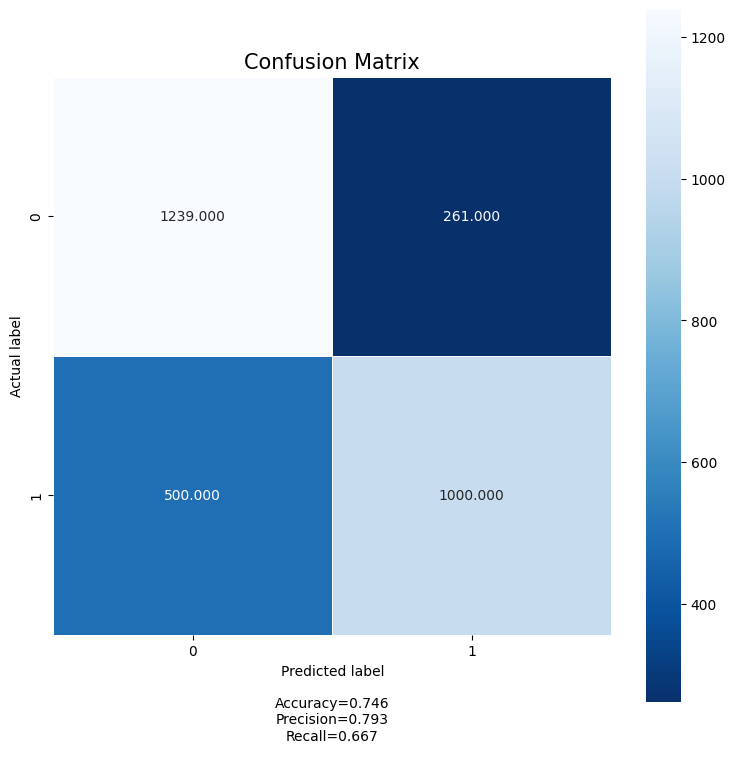

In [ ]:
# Code for confusion matrix adapted from https://towardsdatascience.com/logistic-regression-using-python-sklearn-numpy-mnist-handwriting-recognition-matplotlib-a6b31e2b166a
# Code for stats text adapted from https://github.com/DTrimarchi10/confusion_matrix?source=post_page-----fc31e3f30fea--------------------------------
confusionMatrix = metrics.confusion_matrix(validationLabelsNumeric, predictions)

plt.figure(figsize=(9,9))
sns.heatmap(confusionMatrix, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')


stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\n".format(
                metrics.accuracy_score(validationLabelsNumeric, predictions),metrics.precision_score(validationLabelsNumeric, predictions),metrics.recall_score(validationLabelsNumeric, predictions))
plt.xlabel('Predicted label' + stats_text)
stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\n".format(
                metrics.accuracy_score(validationLabelsNumeric, predictions),metrics.precision_score(validationLabelsNumeric, predictions),metrics.recall_score(validationLabelsNumeric, predictions))
all_sample_title = 'Confusion Matrix'
plt.title(all_sample_title, size = 15)

# Final Takeaways

Overall, this problem was quite a difficult one to tackle, but we believe that we created a good system as a starting point that can be expanded and improved in the future. It was a fun project, and so we can confidently say that we are glad we chose this dataset despite the challenges it presented to us.